# Extract and syncronize the data

In [2]:
import os
import numpy as np
import pandas as pd

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
import matplotlib.pyplot as plt
import seaborn as sns
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

class make_folder_dataset:
    def __init__(self, folder_path:str, save_path) -> None:
        self.path = folder_path
        self.save_path = save_path
        self.num_lines_per_message = 130
        self.df = pd.DataFrame()
        self.df_dataset = pd.DataFrame()
        self.tau = ['tau_J0','tau_J1', 'tau_J2', 'tau_J3', 'tau_J4', 'tau_J5', 'tau_J6']
        self.tau_d = ['tau_J_d0','tau_J_d1', 'tau_J_d2', 'tau_J_d3', 'tau_J_d4', 'tau_J_d5', 'tau_J_d6']
        self.tau_ext =['tau_ext0','tau_ext1','tau_ext2','tau_ext3','tau_ext4','tau_ext5','tau_ext6']

        self.q = ['q0','q1','q2','q3','q4','q5','q6']
        self.q_d = ['q_d0','q_d1','q_d2','q_d3','q_d4','q_d5','q_d6']

        self.dq = ['dq0','dq1','dq2','dq3','dq4','dq5','dq6']
        self.dq_d = ['dq_d0','dq_d1','dq_d2','dq_d3','dq_d4','dq_d5','dq_d6']


        self.e = ['e0','e1','e2','e3','e4','e5','e6']
        self.de = ['de0','de1','de2','de3','de4','de5','de6']
        self.etau = ['etau_J0','etau_J1', 'etau_J2', 'etau_J3', 'etau_J4', 'etau_J5', 'etau_J6']
    
    def _extract_array(self, data_dict:dict, data_frame:str, header:list,  n:int):
            dof = 7
            x, y = data_frame[n].split(':')
            y = y.replace('[','')
            y = y.replace(']','')
            y = y.replace('\n','')

            y = y.split(',')
            for i in range(dof):
                data_dict[header[i]].append(float(y[i]))

    def extract_robot_data(self, ignore_get_label=False):
        # it extracts robot data from all_data.txt
        f = open(self.path + 'all_data.txt', 'r')
        lines = f.readlines()

        keywords = ['time'] + self.tau + self.tau_d + self.tau_ext + self.q + self.q_d + self.dq + self.dq_d 

        data_dict = dict.fromkeys(keywords)
        for i in keywords:
            data_dict[i]=[0]
        
        for i in range(int(len(lines)/self.num_lines_per_message)):
            data_frame = lines[i*self.num_lines_per_message:(i+1)*self.num_lines_per_message]
            
            x, y = data_frame[3].split(':')
            time_ = int(y)-int(int(y)/1000000)*1000000

            x, y = data_frame[4].split(':')
            time_ = time_+int(y)/np.power(10,9)

            data_dict['time'].append(time_)
            
            self._extract_array(data_dict,data_frame,self.tau, 25)
            self._extract_array(data_dict,data_frame,self.tau_d, 26)
            self._extract_array(data_dict,data_frame, self.tau_ext, 37)
            
            self._extract_array(data_dict,data_frame,self.q, 28)
            
            self._extract_array(data_dict,data_frame, self.q_d, 29)
            self._extract_array(data_dict,data_frame, self.dq, 30)
            self._extract_array(data_dict,data_frame, self.dq_d, 31)
        
       
        self.df = pd.DataFrame.from_dict(data_dict)
        self.df = self.df.drop(index=0).reset_index()
        
        for i in range(len(self.e)):
            self.df[self.e[i]] = self.df[self.q_d[i]]-self.df[self.q[i]]
        for i in range(len(self.de)):
            self.df[self.de[i]] = self.df[self.dq_d[i]]-self.df[self.dq[i]]
        for i in range(len(self.etau)):
            self.df[self.etau[i]] = self.df[self.tau_d[i]]-self.df[self.tau[i]]
        self.ros_time = self.df['time'][0]
        self.df.time = self.df.time-self.df.time[0]
        if not ignore_get_label:
            self.get_labels(self.df)
            self.df.to_csv(self.save_path + 'labeled_data.csv', index=False)
            #self.df.to_csv(self.save_path +'robot_data.csv',index=False)

    def get_labels(self, df):
        # it syncronize true labeled (contact- noncontact) data with robot data
        true_label = pd.read_csv(self.path+'true_label.csv')
        true_label['time'] = true_label['time_sec']+true_label['time_nsec']-self.ros_time
        time_dev = true_label['time'].diff()
        contact_events_index = np.append([0], true_label['time'][time_dev>0.05].index.values)
        contact_events_index = np.append(contact_events_index,  true_label['time'].shape[0]-1)
        
        contact_count = 0
        df['label']=0

        for i in range(df['time'].shape[0]):
            if (df['time'][i]-true_label['time'][contact_events_index[contact_count]]) > 0:
                #print(i ,',', contact_events_index[contact_count], ',',self.df['time'][i], '   ', true_label['time'][contact_events_index[contact_count]] )
                contact_count += 1
                if contact_count == len(contact_events_index):
                    break
                for j in range(i, df['time'].shape[0]):
                    df.loc[j, 'label'] = 1
                    #print(j)
                    if (df['time'][j] - true_label['time'][contact_events_index[contact_count]-1]) > 0:
                        #print(j ,',', contact_events_index[contact_count]-1, ',', self.df['time'][j], '   ', true_label['time'][contact_events_index[contact_count]-1] )
                        #print('----------------------------------------')
                        i = j
                        break
        
        return df

    def make_sequence(self):
        #window_time = 140ms
        seq_num = 28
        gap = 4
        selected_features= self.e + self.tau

        dataset = pd.DataFrame(np.ones((int((self.df.shape[0]-seq_num)/gap), seq_num*len(selected_features)+1))*2 )
        index = 0
        state = False
        last_contact_indexes = self.df.loc[self.df['label']==1,'index'].values
        last_contact_indexes = last_contact_indexes[last_contact_indexes.shape[0]-1]

        for i in range(0, last_contact_indexes, gap):
            if state: 
                window = self.df[selected_features][i:i+seq_num]
                dataset.iloc[index,0] = self.df['label'][i+seq_num]
                dataset.iloc[index, 1:len(dataset.columns)] = np.hstack(window.to_numpy())
                index += 1
            else:
                if self.df['label'][i+seq_num] == 1:
                    state = 1
        self.dataset = dataset.drop(index=dataset.loc[dataset[0]==2,0].index)

        name = self.path.split('/')[len(self.path.split('/'))-2]+'.csv'
        self.dataset.to_csv(self.save_path+name, index=False)
        return self.dataset
    
    def split_data(self, train_split_rate = 0.75):
        msk = np.random.rand(len(self.dataset)) < train_split_rate
        train = self.dataset.loc[msk, :]
        test = self.dataset.loc[~msk, :]
        name = self.path.split('/')[len(self.path.split('/'))-2]+'_train.csv'
        train.to_csv(self.save_path+name, index=False)

        name = self.path.split('/')[len(self.path.split('/'))-2]+'_test.csv'
        test.to_csv(self.save_path+name, index=False)

def plot_data(data,plot_label,ytitle, save_path):
    plt.figure(figsize=(10, 6))
    sns.set(style="ticks")
    sns.set_palette("husl")

    # Plot the de columns
    for col in plot_label:
        plt.plot(data['time'], data[col], label='Predicted Contact')

    # Highlight regions where label == 1
    highlight = data['label'] == 1
    for i in range(len(highlight) - 1):
        if highlight.iloc[i]:
            plt.axvspan(data['time'].iloc[i], data['time'].iloc[i + 1], color='lightblue', alpha=0.5)

    # Add a patch for the highlighted region in the legend
    from matplotlib.patches import Patch
    contact_patch = Patch(color='lightblue', alpha=0.5, label='Actual Contact')

    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(contact_patch)
    plt.legend(handles=handles)

    plt.xlabel('Time (sec)')
    plt.ylabel(ytitle)
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()


def data_analysis(robot_data_path, label_data_path, dataset_path):
    # Get a list of all files and directories in the specified directory
    files_and_dirs = os.listdir(robot_data_path)
    for folder_name in files_and_dirs:

        folder_path = robot_data_path + folder_name+'/'
        
        save_data_file = dataset_path + folder_name+'/'
        os.makedirs(save_data_file, exist_ok=True)    
        print(folder_path)
        data = make_folder_dataset(folder_path,save_data_file)
        data.extract_robot_data()
        #data.df.iplot(x='time', y=['label'])

        robot_dof = 7
        num_features = 4*robot_dof
        time_seq = 28
        num_columns = time_seq * num_features 

        header = ['Time_sec', 'Time_nsec', 'prediction_duration', 'contact_out', 'collision_out', 'localization_out'] + [f'val_{i}' for i in range(num_columns)]

        df_model_out= pd.read_csv(folder_path+'model_result.csv', names=header, skiprows=1 )
        df_model_out.head()
        df_model_out['time']=df_model_out.Time_sec+df_model_out.Time_nsec-data.ros_time

        df_model_out=data.get_labels(df_model_out)

        # Calculate correctly detected contacts and detection delay
        true_labels = df_model_out['label'].to_numpy()
        predicted_labels = df_model_out['contact_out']
        detection_delays = []
        true_positive = np.zeros_like(true_labels)
        true_negative = np.zeros_like(true_labels)
        #allowing 250 ms lateny
        n=150
        # detection accuracy and duration
        for i in range(df_model_out.shape[0]-n):
            
            if true_labels[i]:
                state = False
                for j in range(n): 
                    if predicted_labels[i+j]:
                        detection_delays.append(df_model_out.time[i+j]-df_model_out.time[i])
                        true_positive[i]=1
                        state=True
                        break
                if not state:
                    true_positive[i]=0
                # Calculate correctly detected contacts (true negatives)
            else:
                state = False
                for j in range(n): 
                    if not predicted_labels[i+j]:
                        #detection_delays[i]=df_model_out.time[i+j]-df_model_out.time[i]
                        true_negative[i]=1
                        state=True
                        break
                if not state:
                    true_negative[i]=0 

            # Find where the differences are greater than 50
        diff_greater_than_50 = (np.array(detection_delays)>0.04).astype(int)

        # Get the indices where the condition is True, and shift by 1 to get corresponding indices in the original array
        indices = np.where(diff_greater_than_50)[0]
        # Use these indices to get the corresponding elements from detection_delays
        effective_delay = 0
        for i in indices:
            effective_delay = detection_delays[i]+effective_delay
        true_contact = np.sum((true_labels==1).astype(int))
        true_noncontact = np.sum((true_labels==0).astype(int))
        # Print results
        print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {true_contact}, percision: {np.sum(true_positive)/true_contact} ')
        print(f'Correctly detected non-contacts(TN): {np.sum(true_negative)},   non-contact labels: {true_noncontact}, percision: {np.sum(true_negative)/true_noncontact}  ')
        print(f'Effective Detection delay (less than 250 ms): {effective_delay/len(indices):.3f} seconds')
        detection_delays = []
        true_label_index = df_model_out.label[df_model_out.label.diff()>0.9].index
        true_positive= np.zeros_like(true_label_index)
        for i in range(len(true_label_index)):
            state = False
            for j in range(n): 
                if predicted_labels[true_label_index[i]+j]:
                    detection_delays.append(df_model_out.time[true_label_index[i]+j]-df_model_out.time[true_label_index[i]])
                    true_positive[i]=1
                    state=True
                    break
            if not state:
                true_positive[i]=0
        print('Single contact analysis')
        print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
        print(f'Effective Detection delay (less than 250 ms): {np.sum(detection_delays)/len(true_label_index):.3f} seconds')
        plot_data(df_model_out, ['contact_out'],'Label', os.path.join(save_data_file, 'model_prediction.png'))
        #df_model_out.iplot(x='time', y=[ 'label','contact_out'])


# Source Robot

../frankaRobot/DATA/source_robot/2024_07_29_inmotion_link5/
Correctly detected contacts(TP): 12972,   contact labels: 13021, percision: 0.9962368481683435 
Correctly detected non-contacts(TN): 9275,   non-contact labels: 9425, percision: 0.9840848806366048  
Effective Detection delay (less than 250 ms): 0.172 seconds
Single contact analysis
Correctly detected contacts(TP): 102,   contact labels: 102, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.250 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:186: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



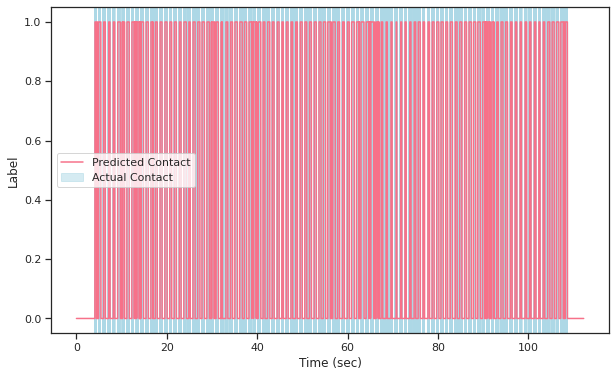

../frankaRobot/DATA/source_robot/2024_07_29_link6/
Correctly detected contacts(TP): 14471,   contact labels: 14471, percision: 1.0 
Correctly detected non-contacts(TN): 11132,   non-contact labels: 11282, percision: 0.9867044850203864  
Effective Detection delay (less than 250 ms): 0.152 seconds
Single contact analysis
Correctly detected contacts(TP): 102,   contact labels: 102, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.251 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:186: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



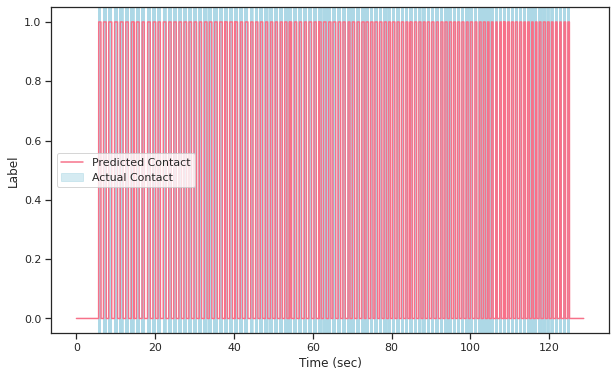

../frankaRobot/DATA/source_robot/2024_07_29_link5/
Correctly detected contacts(TP): 9490,   contact labels: 10010, percision: 0.948051948051948 
Correctly detected non-contacts(TN): 10379,   non-contact labels: 10529, percision: 0.9857536328236299  
Effective Detection delay (less than 250 ms): 0.209 seconds
Single contact analysis
Correctly detected contacts(TP): 96,   contact labels: 102, percision: 0.9411764705882353 
Effective Detection delay (less than 250 ms): 0.338 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:186: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



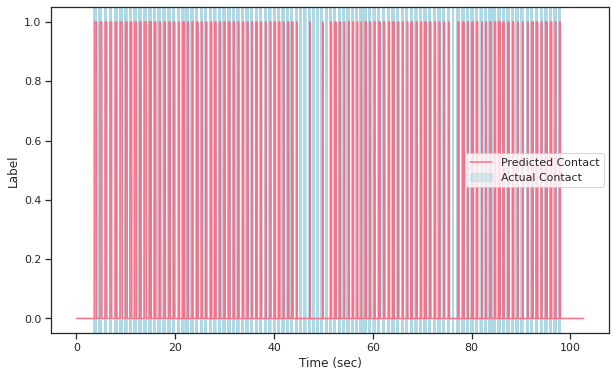

../frankaRobot/DATA/source_robot/2024_07_29_inmotion_link6/
Correctly detected contacts(TP): 11150,   contact labels: 11381, percision: 0.9797030137949213 
Correctly detected non-contacts(TN): 7289,   non-contact labels: 7439, percision: 0.9798359994622933  
Effective Detection delay (less than 250 ms): 0.161 seconds
Single contact analysis
Correctly detected contacts(TP): 101,   contact labels: 103, percision: 0.9805825242718447 
Effective Detection delay (less than 250 ms): 0.205 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:186: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



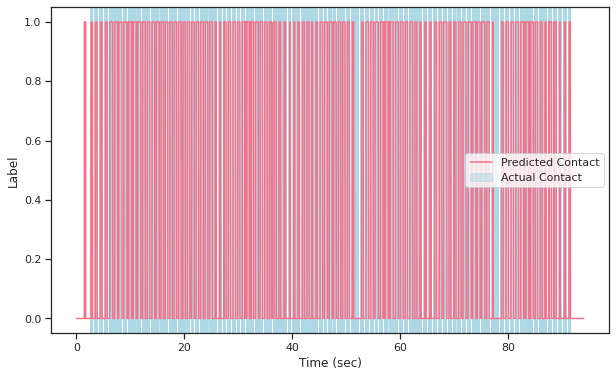

In [3]:
import os
data_path = '../frankaRobot/DATA/source_robot/'
#k=0.25
# Specify the directory you want to list files for
robot_data_path = data_path
label_data_path = data_path
dataset_path = '../frankaRobot/DATA/dataset/'
os.makedirs(dataset_path, exist_ok=True)
data_analysis(robot_data_path, label_data_path, dataset_path)

# Target Robot

../frankaRobot/DATA/target_robot/2024_07_24_link6/
Correctly detected contacts(TP): 9016,   contact labels: 9028, percision: 0.9986708019494904 
Correctly detected non-contacts(TN): 12597,   non-contact labels: 12747, percision: 0.9882325253000706  
Effective Detection delay (less than 250 ms): 0.193 seconds
Single contact analysis
Correctly detected contacts(TP): 68,   contact labels: 68, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.302 seconds


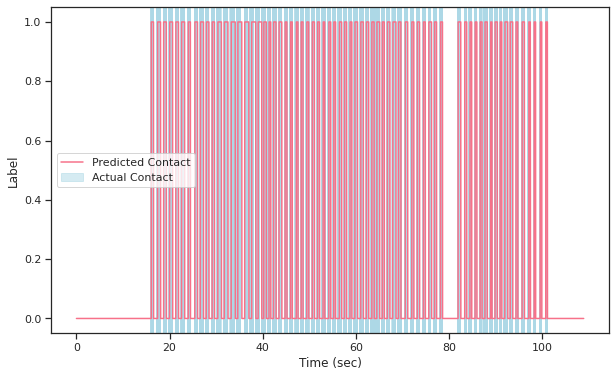

../frankaRobot/DATA/target_robot/2024_07_24_link5/
Correctly detected contacts(TP): 8248,   contact labels: 8248, percision: 1.0 
Correctly detected non-contacts(TN): 11707,   non-contact labels: 11857, percision: 0.9873492451716286  
Effective Detection delay (less than 250 ms): 0.155 seconds
Single contact analysis
Correctly detected contacts(TP): 102,   contact labels: 102, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.242 seconds


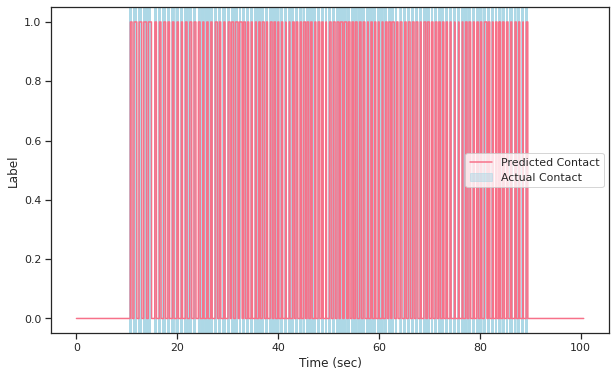

../frankaRobot/DATA/target_robot/2024_07_24_link6_t2/
Correctly detected contacts(TP): 3571,   contact labels: 3571, percision: 1.0 
Correctly detected non-contacts(TN): 7432,   non-contact labels: 7582, percision: 0.9802163017673438  
Effective Detection delay (less than 250 ms): 0.163 seconds
Single contact analysis
Correctly detected contacts(TP): 37,   contact labels: 37, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.261 seconds


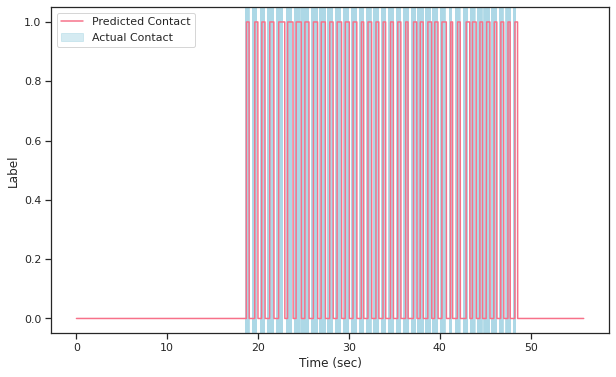

In [28]:
import os
data_path = '../frankaRobot/DATA/target_robot/'

# Specify the directory you want to list files for
robot_data_path = data_path
label_data_path = data_path
dataset_path = '../frankaRobot/DATA/dataset/'
os.makedirs(dataset_path, exist_ok=True)
data_analysis(robot_data_path, label_data_path, dataset_path)


# k=1

## contact detection

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_collision/
Correctly detected contacts(TP): 8731,   contact labels: 8731, percision: 1.0 
Correctly detected non-contacts(TN): 15605,   non-contact labels: 15755, percision: 0.9904792129482703  
Effective Detection delay (less than 750 ms): 0.088 seconds
Single contact analysis
Correctly detected contacts(TP): 99,   contact labels: 99, percision: 1.0 
Effective Detection delay (less than 750 ms): 0.122 seconds


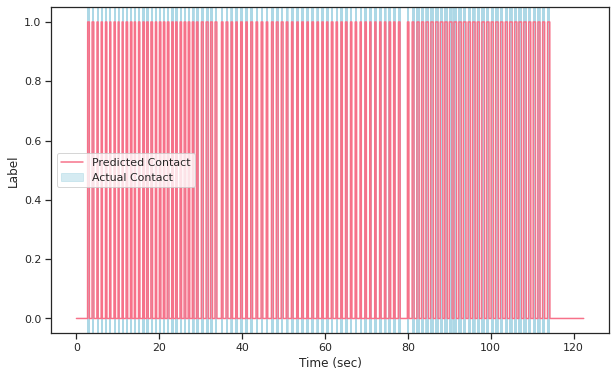

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collaborative/
Correctly detected contacts(TP): 12259,   contact labels: 12259, percision: 1.0 
Correctly detected non-contacts(TN): 6793,   non-contact labels: 6943, percision: 0.9783955062653031  
Effective Detection delay (less than 750 ms): 0.134 seconds
Single contact analysis
Correctly detected contacts(TP): 104,   contact labels: 104, percision: 1.0 
Effective Detection delay (less than 750 ms): 0.205 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



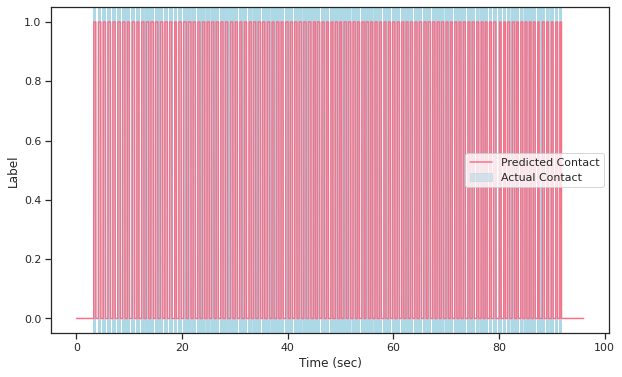

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_colaborative/
Correctly detected contacts(TP): 6578,   contact labels: 6578, percision: 1.0 
Correctly detected non-contacts(TN): 15719,   non-contact labels: 15869, percision: 0.9905476085449618  
Effective Detection delay (less than 750 ms): 0.062 seconds
Single contact analysis
Correctly detected contacts(TP): 81,   contact labels: 81, percision: 1.0 
Effective Detection delay (less than 750 ms): 0.032 seconds


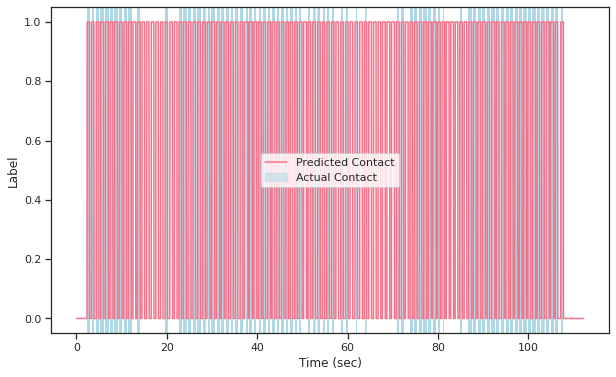

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collision/
Correctly detected contacts(TP): 12004,   contact labels: 12004, percision: 1.0 
Correctly detected non-contacts(TN): 9964,   non-contact labels: 10114, percision: 0.9851690725726715  
Effective Detection delay (less than 750 ms): 0.106 seconds
Single contact analysis
Correctly detected contacts(TP): 103,   contact labels: 103, percision: 1.0 
Effective Detection delay (less than 750 ms): 0.150 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



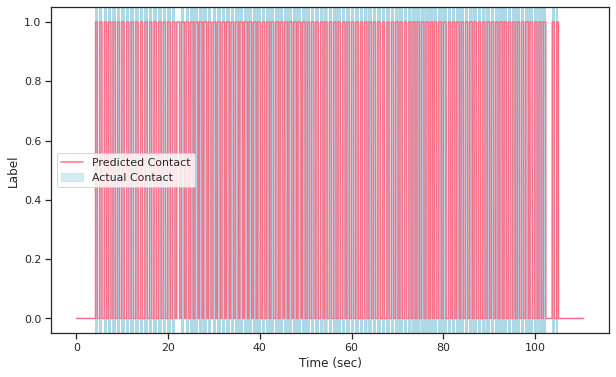

In [5]:
data_path = '../frankaRobot/DATA/target_robot/k_1/'
target_label = 'contact_out'

# Specify the directory you want to list files for
robot_data_path = data_path
label_data_path = data_path
dataset_path = '../frankaRobot/DATA/dataset/'
os.makedirs(dataset_path, exist_ok=True)
files_and_dirs = os.listdir(robot_data_path)
for folder_name in files_and_dirs:

    folder_path = robot_data_path + folder_name+'/'
    
    save_data_file = dataset_path + folder_name+'/'
    os.makedirs(save_data_file, exist_ok=True)    
    print(folder_path)
    data = make_folder_dataset(folder_path,save_data_file)
    data.extract_robot_data(ignore_get_label=True)
    #data.df.iplot(x='time', y=['label'])

    robot_dof = 7
    num_features = 4*robot_dof
    time_seq = 28
    num_columns = time_seq * num_features 

    header = ['Time_sec', 'Time_nsec', 'prediction_duration', 'contact_out', 'collision_out', 'localization_out'] + [f'val_{i}' for i in range(num_columns)]

    df_model_out= pd.read_csv(folder_path+'model_result.csv', names=header, skiprows=1 )
    df_model_out.head()
    df_model_out['time']=df_model_out.Time_sec+df_model_out.Time_nsec-data.ros_time

    df_model_out=data.get_labels(df_model_out)

    # Calculate correctly detected contacts and detection delay
    true_labels = df_model_out['label'].to_numpy()
    predicted_labels = df_model_out[target_label]
    detection_delays = []
    true_positive = np.zeros_like(true_labels)
    true_negative = np.zeros_like(true_labels)
    #allowing 250 ms lateny
    n=150
    # detection accuracy and duration
    for i in range(df_model_out.shape[0]-n):
        
        if true_labels[i]:
            state = False
            for j in range(n): 
                if predicted_labels[i+j]:
                    detection_delays.append(df_model_out.time[i+j]-df_model_out.time[i])
                    true_positive[i]=1
                    state=True
                    break
            if not state:
                true_positive[i]=0
            # Calculate correctly detected contacts (true negatives)
        else:
            state = False
            for j in range(n): 
                if not predicted_labels[i+j]:
                    #detection_delays[i]=df_model_out.time[i+j]-df_model_out.time[i]
                    true_negative[i]=1
                    state=True
                    break
            if not state:
                true_negative[i]=0 

        # Find where the differences are greater than 50
    diff_greater_than_50 = (np.array(detection_delays)>0.04).astype(int)

    # Get the indices where the condition is True, and shift by 1 to get corresponding indices in the original array
    indices = np.where(diff_greater_than_50)[0]
    # Use these indices to get the corresponding elements from detection_delays
    effective_delay = 0
    for i in indices:
        effective_delay = detection_delays[i]+effective_delay
    true_contact = np.sum((true_labels==1).astype(int))
    true_noncontact = np.sum((true_labels==0).astype(int))
    # Print results
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {true_contact}, percision: {np.sum(true_positive)/true_contact} ')
    print(f'Correctly detected non-contacts(TN): {np.sum(true_negative)},   non-contact labels: {true_noncontact}, percision: {np.sum(true_negative)/true_noncontact}  ')
    print(f'Effective Detection delay (less than 750 ms): {effective_delay/len(indices):.3f} seconds')
    detection_delays = []
    true_label_index = df_model_out.label[df_model_out.label.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    for i in range(len(true_label_index)):
        state = False
        for j in range(n): 
            if predicted_labels[true_label_index[i]+j]:
                detection_delays.append(df_model_out.time[true_label_index[i]+j]-df_model_out.time[true_label_index[i]])
                true_positive[i]=1
                state=True
                break
        if not state:
            true_positive[i]=0
    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay (less than 750 ms): {np.sum(detection_delays)/len(true_label_index):.3f} seconds')
    plot_data(df_model_out, ['contact_out'],'Label', os.path.join(save_data_file, 'model_prediction.png'))
    #df_model_out.iplot(x='time', y=[ 'label','contact_out'])

## localization

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_collision/
Correctly detected contacts(TP): 2215,   contact labels: 8731, percision: 0.2536937349673577 
Correctly detected non-contacts(TN): 15605,   non-contact labels: 15755, percision: 0.9904792129482703  
Effective Detection delay (less than 750 ms): 0.268 seconds
Single contact analysis
Correctly detected contacts(TP): 29,   contact labels: 99, percision: 0.29292929292929293 
Effective Detection delay (less than 750 ms): 0.132 seconds


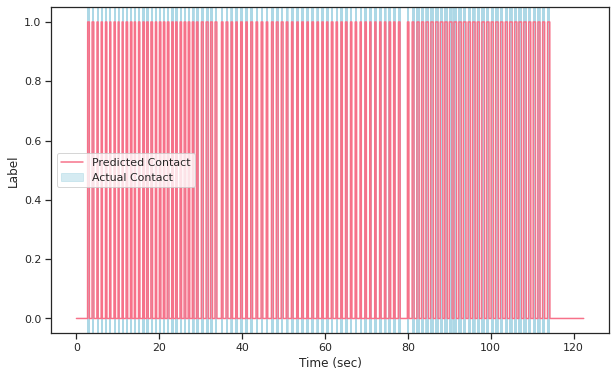

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collaborative/
Correctly detected contacts(TP): 12259,   contact labels: 12259, percision: 1.0 
Correctly detected non-contacts(TN): 6793,   non-contact labels: 6943, percision: 0.9783955062653031  
Effective Detection delay (less than 750 ms): 0.143 seconds
Single contact analysis
Correctly detected contacts(TP): 104,   contact labels: 104, percision: 1.0 
Effective Detection delay (less than 750 ms): 0.209 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



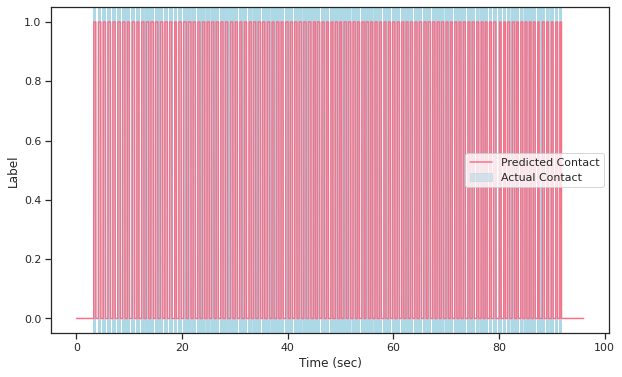

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_colaborative/
Correctly detected contacts(TP): 6578,   contact labels: 6578, percision: 1.0 
Correctly detected non-contacts(TN): 15719,   non-contact labels: 15869, percision: 0.9905476085449618  
Effective Detection delay (less than 750 ms): 0.234 seconds
Single contact analysis
Correctly detected contacts(TP): 81,   contact labels: 81, percision: 1.0 
Effective Detection delay (less than 750 ms): 0.121 seconds


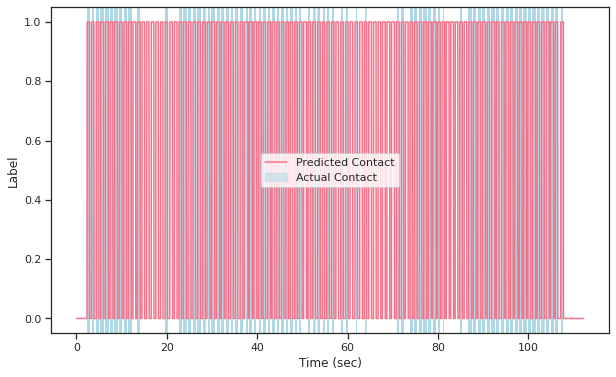

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collision/
Correctly detected contacts(TP): 11826,   contact labels: 12004, percision: 0.9851716094635121 
Correctly detected non-contacts(TN): 9964,   non-contact labels: 10114, percision: 0.9851690725726715  
Effective Detection delay (less than 750 ms): 0.187 seconds
Single contact analysis
Correctly detected contacts(TP): 102,   contact labels: 103, percision: 0.9902912621359223 
Effective Detection delay (less than 750 ms): 0.174 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



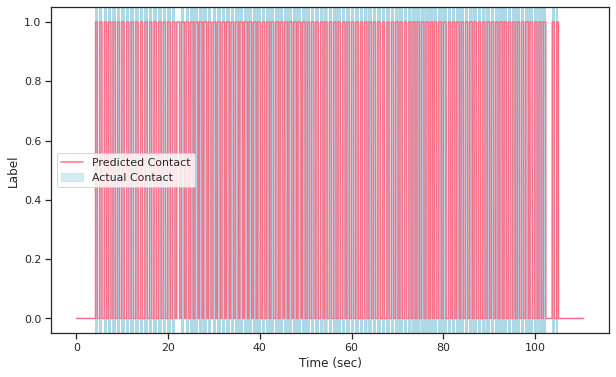

In [6]:
data_path = '../frankaRobot/DATA/target_robot/k_1/'
target_label = 'localization_out'

# Specify the directory you want to list files for
robot_data_path = data_path
label_data_path = data_path
dataset_path = '../frankaRobot/DATA/dataset/'
os.makedirs(dataset_path, exist_ok=True)
files_and_dirs = os.listdir(robot_data_path)
for folder_name in files_and_dirs:

    folder_path = robot_data_path + folder_name+'/'
    
    save_data_file = dataset_path + folder_name+'/'
    os.makedirs(save_data_file, exist_ok=True)    
    print(folder_path)
    data = make_folder_dataset(folder_path,save_data_file)
    data.extract_robot_data(ignore_get_label=True)
    #data.df.iplot(x='time', y=['label'])

    robot_dof = 7
    num_features = 4*robot_dof
    time_seq = 28
    num_columns = time_seq * num_features 

    header = ['Time_sec', 'Time_nsec', 'prediction_duration', 'contact_out', 'collision_out', 'localization_out'] + [f'val_{i}' for i in range(num_columns)]

    df_model_out= pd.read_csv(folder_path+'model_result.csv', names=header, skiprows=1 )
    df_model_out.head()
    df_model_out['time']=df_model_out.Time_sec+df_model_out.Time_nsec-data.ros_time

    df_model_out=data.get_labels(df_model_out)

    # Calculate correctly detected contacts and detection delay
    true_labels = df_model_out['label'].to_numpy()
    predicted_labels = df_model_out[target_label]
    detection_delays = []
    true_positive = np.zeros_like(true_labels)
    true_negative = np.zeros_like(true_labels)
    #allowing 250 ms lateny
    n=150
    # detection accuracy and duration
    for i in range(df_model_out.shape[0]-n):
        
        if true_labels[i]:
            state = False
            for j in range(n): 
                if predicted_labels[i+j]:
                    detection_delays.append(df_model_out.time[i+j]-df_model_out.time[i])
                    true_positive[i]=1
                    state=True
                    break
            if not state:
                true_positive[i]=0
            # Calculate correctly detected contacts (true negatives)
        else:
            state = False
            for j in range(n): 
                if not predicted_labels[i+j]:
                    #detection_delays[i]=df_model_out.time[i+j]-df_model_out.time[i]
                    true_negative[i]=1
                    state=True
                    break
            if not state:
                true_negative[i]=0 

        # Find where the differences are greater than 50
    diff_greater_than_50 = (np.array(detection_delays)>0.04).astype(int)

    # Get the indices where the condition is True, and shift by 1 to get corresponding indices in the original array
    indices = np.where(diff_greater_than_50)[0]
    # Use these indices to get the corresponding elements from detection_delays
    effective_delay = 0
    for i in indices:
        effective_delay = detection_delays[i]+effective_delay
    true_contact = np.sum((true_labels==1).astype(int))
    true_noncontact = np.sum((true_labels==0).astype(int))
    # Print results
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {true_contact}, percision: {np.sum(true_positive)/true_contact} ')
    print(f'Correctly detected non-contacts(TN): {np.sum(true_negative)},   non-contact labels: {true_noncontact}, percision: {np.sum(true_negative)/true_noncontact}  ')
    print(f'Effective Detection delay (less than 750 ms): {effective_delay/len(indices):.3f} seconds')
    detection_delays = []
    true_label_index = df_model_out.label[df_model_out.label.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    for i in range(len(true_label_index)):
        state = False
        for j in range(n): 
            if predicted_labels[true_label_index[i]+j]:
                detection_delays.append(df_model_out.time[true_label_index[i]+j]-df_model_out.time[true_label_index[i]])
                true_positive[i]=1
                state=True
                break
        if not state:
            true_positive[i]=0
    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay (less than 750 ms): {np.sum(detection_delays)/len(true_label_index):.3f} seconds')
    plot_data(df_model_out, ['contact_out'],'Label', os.path.join(save_data_file, 'model_prediction.png'))
    #df_model_out.iplot(x='time', y=[ 'label','contact_out'])

## collision

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_collision/
Correctly detected contacts(TP): 8189,   contact labels: 8731, percision: 0.9379223456648723 
Correctly detected non-contacts(TN): 15605,   non-contact labels: 15755, percision: 0.9904792129482703  
Effective Detection delay (less than 750 ms): 0.129 seconds
Single contact analysis
Correctly detected contacts(TP): 97,   contact labels: 99, percision: 0.9797979797979798 
Effective Detection delay (less than 750 ms): 0.175 seconds


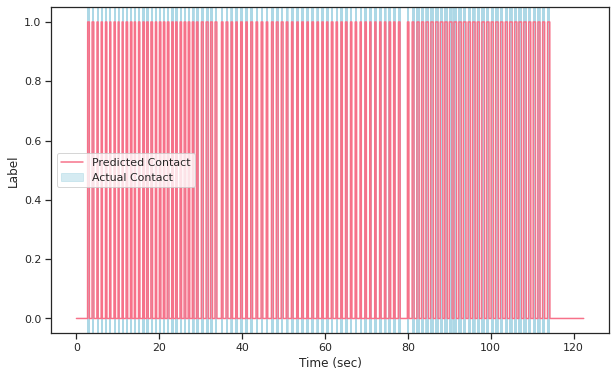

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collaborative/
Correctly detected contacts(TP): 721,   contact labels: 12259, percision: 0.05881393262093156 
Correctly detected non-contacts(TN): 6793,   non-contact labels: 6943, percision: 0.9783955062653031  
Effective Detection delay (less than 750 ms): 0.299 seconds
Single contact analysis
Correctly detected contacts(TP): 7,   contact labels: 104, percision: 0.0673076923076923 
Effective Detection delay (less than 750 ms): 0.021 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



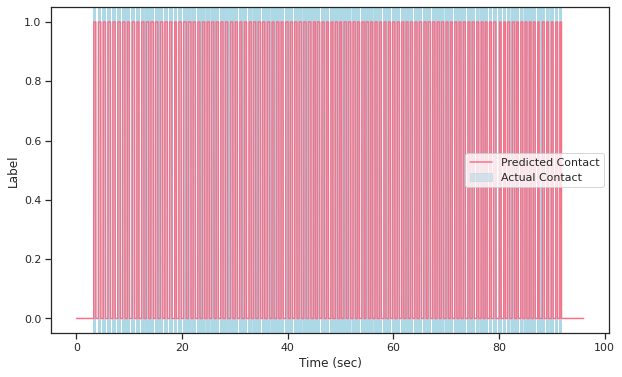

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_colaborative/
Correctly detected contacts(TP): 301,   contact labels: 6578, percision: 0.045758589236850104 
Correctly detected non-contacts(TN): 15719,   non-contact labels: 15869, percision: 0.9905476085449618  
Effective Detection delay (less than 750 ms): 0.211 seconds
Single contact analysis
Correctly detected contacts(TP): 5,   contact labels: 81, percision: 0.06172839506172839 
Effective Detection delay (less than 750 ms): 0.013 seconds


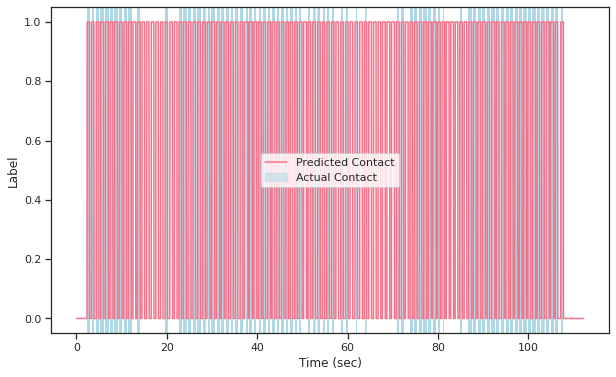

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collision/
Correctly detected contacts(TP): 12004,   contact labels: 12004, percision: 1.0 
Correctly detected non-contacts(TN): 9964,   non-contact labels: 10114, percision: 0.9851690725726715  
Effective Detection delay (less than 750 ms): 0.170 seconds
Single contact analysis
Correctly detected contacts(TP): 103,   contact labels: 103, percision: 1.0 
Effective Detection delay (less than 750 ms): 0.211 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



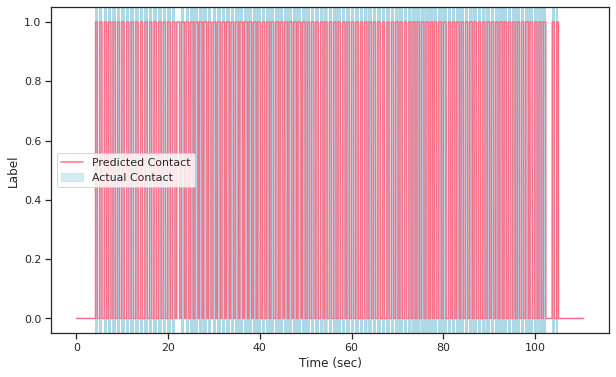

In [7]:
data_path = '../frankaRobot/DATA/target_robot/k_1/'
target_label = 'collision_out'

# Specify the directory you want to list files for
robot_data_path = data_path
label_data_path = data_path
dataset_path = '../frankaRobot/DATA/dataset/'
os.makedirs(dataset_path, exist_ok=True)
files_and_dirs = os.listdir(robot_data_path)
for folder_name in files_and_dirs:

    folder_path = robot_data_path + folder_name+'/'
    
    save_data_file = dataset_path + folder_name+'/'
    os.makedirs(save_data_file, exist_ok=True)    
    print(folder_path)
    data = make_folder_dataset(folder_path,save_data_file)
    data.extract_robot_data(ignore_get_label=True)
    #data.df.iplot(x='time', y=['label'])

    robot_dof = 7
    num_features = 4*robot_dof
    time_seq = 28
    num_columns = time_seq * num_features 

    header = ['Time_sec', 'Time_nsec', 'prediction_duration', 'contact_out', 'collision_out', 'localization_out'] + [f'val_{i}' for i in range(num_columns)]

    df_model_out= pd.read_csv(folder_path+'model_result.csv', names=header, skiprows=1 )
    df_model_out.head()
    df_model_out['time']=df_model_out.Time_sec+df_model_out.Time_nsec-data.ros_time

    df_model_out=data.get_labels(df_model_out)

    # Calculate correctly detected contacts and detection delay
    true_labels = df_model_out['label'].to_numpy()
    predicted_labels = df_model_out[target_label]
    detection_delays = []
    true_positive = np.zeros_like(true_labels)
    true_negative = np.zeros_like(true_labels)
    #allowing 250 ms lateny
    n=150
    # detection accuracy and duration
    for i in range(df_model_out.shape[0]-n):
        
        if true_labels[i]:
            state = False
            for j in range(n): 
                if predicted_labels[i+j]:
                    detection_delays.append(df_model_out.time[i+j]-df_model_out.time[i])
                    true_positive[i]=1
                    state=True
                    break
            if not state:
                true_positive[i]=0
            # Calculate correctly detected contacts (true negatives)
        else:
            state = False
            for j in range(n): 
                if not predicted_labels[i+j]:
                    #detection_delays[i]=df_model_out.time[i+j]-df_model_out.time[i]
                    true_negative[i]=1
                    state=True
                    break
            if not state:
                true_negative[i]=0 

        # Find where the differences are greater than 50
    diff_greater_than_50 = (np.array(detection_delays)>0.04).astype(int)

    # Get the indices where the condition is True, and shift by 1 to get corresponding indices in the original array
    indices = np.where(diff_greater_than_50)[0]
    # Use these indices to get the corresponding elements from detection_delays
    effective_delay = 0
    for i in indices:
        effective_delay = detection_delays[i]+effective_delay
    true_contact = np.sum((true_labels==1).astype(int))
    true_noncontact = np.sum((true_labels==0).astype(int))
    # Print results
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {true_contact}, percision: {np.sum(true_positive)/true_contact} ')
    print(f'Correctly detected non-contacts(TN): {np.sum(true_negative)},   non-contact labels: {true_noncontact}, percision: {np.sum(true_negative)/true_noncontact}  ')
    print(f'Effective Detection delay (less than 750 ms): {effective_delay/len(indices):.3f} seconds')
    detection_delays = []
    true_label_index = df_model_out.label[df_model_out.label.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    for i in range(len(true_label_index)):
        state = False
        for j in range(n): 
            if predicted_labels[true_label_index[i]+j]:
                detection_delays.append(df_model_out.time[true_label_index[i]+j]-df_model_out.time[true_label_index[i]])
                true_positive[i]=1
                state=True
                break
        if not state:
            true_positive[i]=0
    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay (less than 750 ms): {np.sum(detection_delays)/len(true_label_index):.3f} seconds')
    plot_data(df_model_out, ['contact_out'],'Label', os.path.join(save_data_file, 'model_prediction.png'))
    #df_model_out.iplot(x='time', y=[ 'label','contact_out'])

# K=1, correcting accuracy calculation for other labels

In [15]:
import re

def extract_labels(text):
    # Initialize labels
    localization_out = 0
    collision_label = 0
    
    # Check for link5 or link6
    if 'link6' in text:
        localization_out = 1
    elif 'link5' in text:
        localization_out = 0
    
    # Check for collaborative or collision
    if 'collision' in text:
        collision_label = 1
    elif 'collaborative' in text:
        collision_label = 0
    
    return localization_out, collision_label

data_path = '../frankaRobot/DATA/target_robot/k_1/'
# Specify the directory you want to list files for
robot_data_path = data_path
label_data_path = data_path
dataset_path = '../frankaRobot/DATA/dataset/'
os.makedirs(dataset_path, exist_ok=True)
files_and_dirs = os.listdir(robot_data_path)
for folder_name in files_and_dirs:
    
    target_localization, target_collision = extract_labels(folder_name)

    folder_path = robot_data_path + folder_name+'/'
    
    save_data_file = dataset_path + folder_name+'/'
    os.makedirs(save_data_file, exist_ok=True)    
    print(folder_path)
    data = make_folder_dataset(folder_path,save_data_file)
    data.extract_robot_data(ignore_get_label=True)
    #data.df.iplot(x='time', y=['label'])

    robot_dof = 7
    num_features = 4*robot_dof
    time_seq = 28
    num_columns = time_seq * num_features 

    header = ['Time_sec', 'Time_nsec', 'prediction_duration', 'contact_out', 'collision_out', 'localization_out'] + [f'val_{i}' for i in range(num_columns)]

    df_model_out= pd.read_csv(folder_path+'model_result.csv', names=header, skiprows=1 )
    df_model_out.head()
    df_model_out['time']=df_model_out.Time_sec+df_model_out.Time_nsec-data.ros_time

    df_model_out=data.get_labels(df_model_out)

    # Calculate correctly detected contacts and detection delay
    true_labels = df_model_out['label'].to_numpy()
    predicted_labels_contact = df_model_out['contact_out']
    predicted_labels_localization = df_model_out['localization_out']
    predicted_labels_collision = df_model_out['collision_out']
    
    detection_delays = []
    true_positive_localization = []
    true_positive_collision = []
    #allowing 250 ms lateny
    n=150
    # detection accuracy and duration
    for i in range(df_model_out.shape[0]-n):
        
        if predicted_labels_contact[i]:
            if target_localization == predicted_labels_localization[i]:
                true_positive_localization.append(1)
            else:
                true_positive_localization.append(0)
        
            if target_collision == predicted_labels_collision[i]:
                true_positive_collision.append(1)
            else:
                true_positive_collision.append(0)

    print(f'Correctly detected collision_out(TP): {np.sum(true_positive_collision)},   trails: {len(true_positive_collision)}, percision: {np.sum(true_positive_collision)/len(true_positive_collision)} ')
    print(f'Correctly detected localization_out(TP): {np.sum(true_positive_localization)},   trails: {len(true_positive_localization)}, percision: {np.sum(true_positive_localization)/len(true_positive_localization)} ')

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_collision/
Correctly detected collision_out(TP): 4470,   trails: 8374, percision: 0.5337950800095533 
Correctly detected localization_out(TP): 8202,   trails: 8374, percision: 0.9794602340577979 
../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collaborative/
Correctly detected collision_out(TP): 8267,   trails: 8388, percision: 0.9855746304244158 
Correctly detected localization_out(TP): 7488,   trails: 8388, percision: 0.8927038626609443 
../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_collaborative/
Correctly detected collision_out(TP): 12516,   trails: 12597, percision: 0.9935698975946654 
Correctly detected localization_out(TP): 8290,   trails: 12597, percision: 0.6580931967928872 
../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collision/
Correctly detected collision_out(TP): 7699,   trails: 11298, percision: 0.6814480439015755 
Correctly detected localization_out(TP): 7033,   trails: 11298, percision: 0.62249

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_collision/
Correctly detected combined labels (TP): 4470, trails: 8374, precision: 0.53


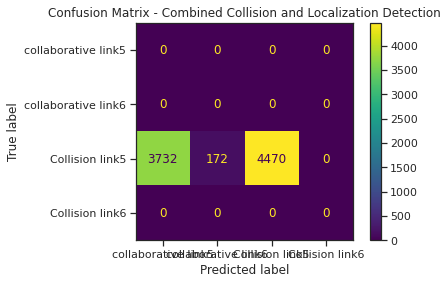

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collaborative/
Correctly detected combined labels (TP): 7369, trails: 8388, precision: 0.88


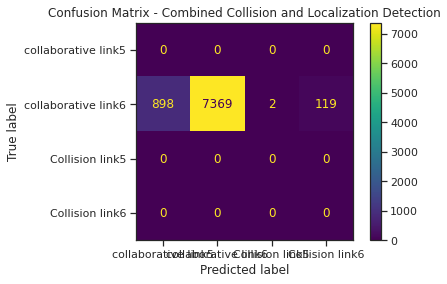

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link5_collaborative/
Correctly detected combined labels (TP): 8209, trails: 12597, precision: 0.65


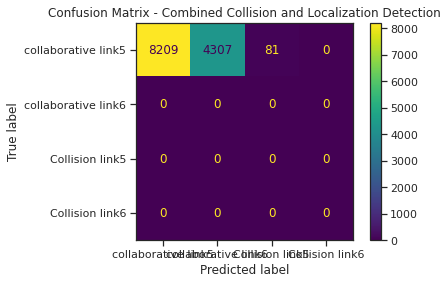

../frankaRobot/DATA/target_robot/k_1/2024_08_08_link6_collision/
Correctly detected combined labels (TP): 5602, trails: 11298, precision: 0.50


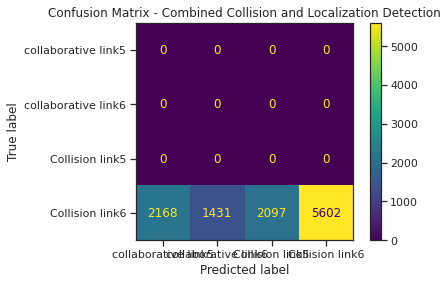

In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def extract_labels(text):
    # Initialize labels
    localization_out = 0
    collision_label = 0
    
    # Check for link5 or link6
    if 'link6' in text:
        localization_out = 1
    elif 'link5' in text:
        localization_out = 0
    
    # Check for collaborative or collision
    if 'collision' in text:
        collision_label = 1
    elif 'collaborative' in text:
        collision_label = 0
    
    return localization_out, collision_label

data_path = '../frankaRobot/DATA/target_robot/k_1/'
# Specify the directory you want to list files for
robot_data_path = data_path
label_data_path = data_path
dataset_path = '../frankaRobot/DATA/dataset/'
os.makedirs(dataset_path, exist_ok=True)
files_and_dirs = os.listdir(robot_data_path)

for folder_name in files_and_dirs:
    
    target_localization, target_collision = extract_labels(folder_name)

    folder_path = robot_data_path + folder_name + '/'
    
    save_data_file = dataset_path + folder_name + '/'
    os.makedirs(save_data_file, exist_ok=True)    
    print(folder_path)
    
    # Assuming make_folder_dataset is defined somewhere in your code
    data = make_folder_dataset(folder_path, save_data_file)
    data.extract_robot_data(ignore_get_label=True)

    robot_dof = 7
    num_features = 4 * robot_dof
    time_seq = 28
    num_columns = time_seq * num_features 

    header = ['Time_sec', 'Time_nsec', 'prediction_duration', 'contact_out', 
              'collision_out', 'localization_out'] + [f'val_{i}' for i in range(num_columns)]

    df_model_out = pd.read_csv(folder_path + 'model_result.csv', names=header, skiprows=1)
    df_model_out['time'] = df_model_out.Time_sec + df_model_out.Time_nsec - data.ros_time

    df_model_out = data.get_labels(df_model_out)

    # True labels (assumed to be generated correctly by `data.get_labels`)
    true_labels = df_model_out['label'].to_numpy()

    # Predicted labels
    predicted_labels_contact = df_model_out['contact_out'].to_numpy()
    predicted_labels_localization = df_model_out['localization_out'].astype(int).to_numpy()
    predicted_labels_collision = df_model_out['collision_out'].astype(int).to_numpy()
    
    detection_delays = []
    combined_true_labels = []
    combined_pred_labels = []

    # Allowing 250 ms latency (n=150)
    n = 150
    
    # Combine the collision and localization labels for confusion matrix
    for i in range(df_model_out.shape[0] - n):
        if predicted_labels_contact[i]:
            true_combined = (target_collision << 1) | target_localization
            pred_combined = (predicted_labels_collision[i] << 1) | predicted_labels_localization[i]
            
            combined_true_labels.append(true_combined)
            combined_pred_labels.append(pred_combined)

    # Convert lists to arrays
    combined_true_labels = np.array(combined_true_labels)
    combined_pred_labels = np.array(combined_pred_labels)
    
    # Print results
    precision = np.sum(combined_true_labels == combined_pred_labels) / len(combined_true_labels)
    print(f'Correctly detected combined labels (TP): {np.sum(combined_true_labels == combined_pred_labels)}, trails: {len(combined_true_labels)}, precision: {precision:.2f}')
    
    # Confusion Matrix
    cm_combined = confusion_matrix(combined_true_labels, combined_pred_labels, labels=[0, 1, 2, 3])
    
    # Plot confusion matrix
    ConfusionMatrixDisplay(cm_combined, display_labels=['collaborative link5', 
                                                        'collaborative link6', 
                                                        'Collision link5', 
                                                        'Collision link6']).plot()
    plt.title('Confusion Matrix - Combined Collision and Localization Detection')
    plt.show()


In [27]:
print((81+8209)/(8209+4307+81))
print((4307+8209)/(8209+4307+81))

print((7369+119)/(898+7369+2+119))
print((898+7369)/(898+7369+2+119))

print((4470+3732)/(4470+3732+172))
print((4470)/(4470+3732+172))

print((1431+5602)/(2168+2097+1431+5602))
print((2097+5602)/(2168+2097+1431+5602))

0.6580931967928872
0.9935698975946654
0.8927038626609443
0.9855746304244158
0.9794602340577979
0.5337950800095533
0.6224995574437954
0.6814480439015755
